In [47]:
import pandas as pd
import numpy as np
import pandas_profiling as pf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sklearn.metrics as metric
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# import xgboost as xg
import lightgbm as lgbm

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

sns.set_theme(style = 'whitegrid')
current_palette = sns.color_palette("Paired")
sns.set_palette(current_palette)

In [3]:
data = pd.read_csv('in-vehicle-coupon-recommendation.csv')

In [4]:
data.shape

(12684, 26)

In [5]:
data.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
data.shape

(12684, 26)

### Checking the Null values in all the columns of the dataset

In [7]:
data.isnull().sum().sort_values(ascending=False)

car                     12576
CoffeeHouse               217
Restaurant20To50          189
CarryAway                 151
RestaurantLessThan20      130
Bar                       107
destination                 0
passanger                   0
direction_opp               0
direction_same              0
toCoupon_GEQ25min           0
toCoupon_GEQ15min           0
toCoupon_GEQ5min            0
income                      0
occupation                  0
education                   0
has_children                0
maritalStatus               0
age                         0
gender                      0
expiration                  0
coupon                      0
time                        0
temperature                 0
weather                     0
Y                           0
dtype: int64

## Notes:
### Above data has different columns with NaN values, and among them 'car' column has the highest count.

In [8]:
data.shape

(12684, 26)

In [9]:
# calculating Null values percentage of the 'car' variable
(data.isnull().sum().sort_values(ascending=False)[0]/data.shape[0])*100

99.14853358561967

In [10]:
# from the above info we can clearly observe that the 'car' column is not useful as it has 99.14% of the missing value
# removing the column 'car'

data.drop(columns=['car'], inplace=True)

In [11]:
data.corr()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
temperature,1.000000,-0.019716,NaN,-0.155332,-0.216254,0.097085,-0.097085,0.061240
has_children,-0.019716,1.000000,NaN,0.078211,-0.013722,-0.031620,0.031620,-0.045557
toCoupon_GEQ5min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toCoupon_GEQ15min,-0.155332,0.078211,NaN,1.000000,0.324984,-0.303533,0.303533,-0.081602
toCoupon_GEQ25min,-0.216254,-0.013722,NaN,0.324984,1.000000,-0.192319,0.192319,-0.103633
direction_same,0.097085,-0.031620,NaN,-0.303533,-0.192319,1.000000,-1.000000,0.014570
direction_opp,-0.097085,0.031620,NaN,0.303533,0.192319,-1.000000,1.000000,-0.014570
Y,0.061240,-0.045557,NaN,-0.081602,-0.103633,0.014570,-0.014570,1.000000


In [12]:
len(data.select_dtypes(include=['object']).columns)

17

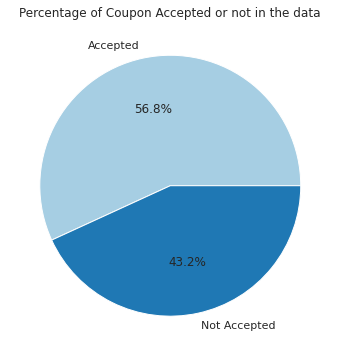

In [13]:
plt.figure(figsize=(10,6))
plt.pie(data.Y.value_counts(),labels=['Accepted','Not Accepted'], autopct='%.1f%%')
plt.title("Percentage of Coupon Accepted or not in the data")
plt.savefig('percent_ratio.jpeg')
plt.show()

<AxesSubplot:ylabel='Y'>

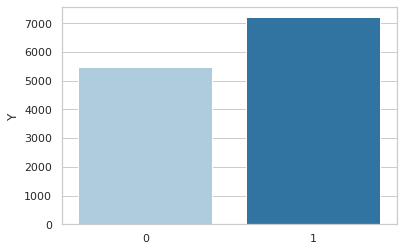

In [14]:
sns.barplot(x=data.Y.value_counts().index, y=data.Y.value_counts())

In [15]:
# changing the data type of the categorical columns to category from object dtype

data_object = data.select_dtypes(include=['object']).copy()

for col in data_object.columns:
    data[col]=data[col].astype('category')
    
data.dtypes


destination             category
passanger               category
weather                 category
temperature                int64
time                    category
coupon                  category
expiration              category
gender                  category
age                     category
maritalStatus           category
has_children               int64
education               category
occupation              category
income                  category
Bar                     category
CoffeeHouse             category
CarryAway               category
RestaurantLessThan20    category
Restaurant20To50        category
toCoupon_GEQ5min           int64
toCoupon_GEQ15min          int64
toCoupon_GEQ25min          int64
direction_same             int64
direction_opp              int64
Y                          int64
dtype: object

In [16]:
data.select_dtypes(include=['int64']).nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

In [17]:
data['toCoupon_GEQ5min']

0        1
1        1
2        1
3        1
4        1
        ..
12679    1
12680    1
12681    1
12682    1
12683    1
Name: toCoupon_GEQ5min, Length: 12684, dtype: int64

### It is clearly evident that the column 'toCoupon_GEQ5min' has only one unique value which will not be of any help for the model.

In [18]:
# dropping toCoupon_GEQ5min column from the data
data.drop(columns=['toCoupon_GEQ5min'], inplace=True)

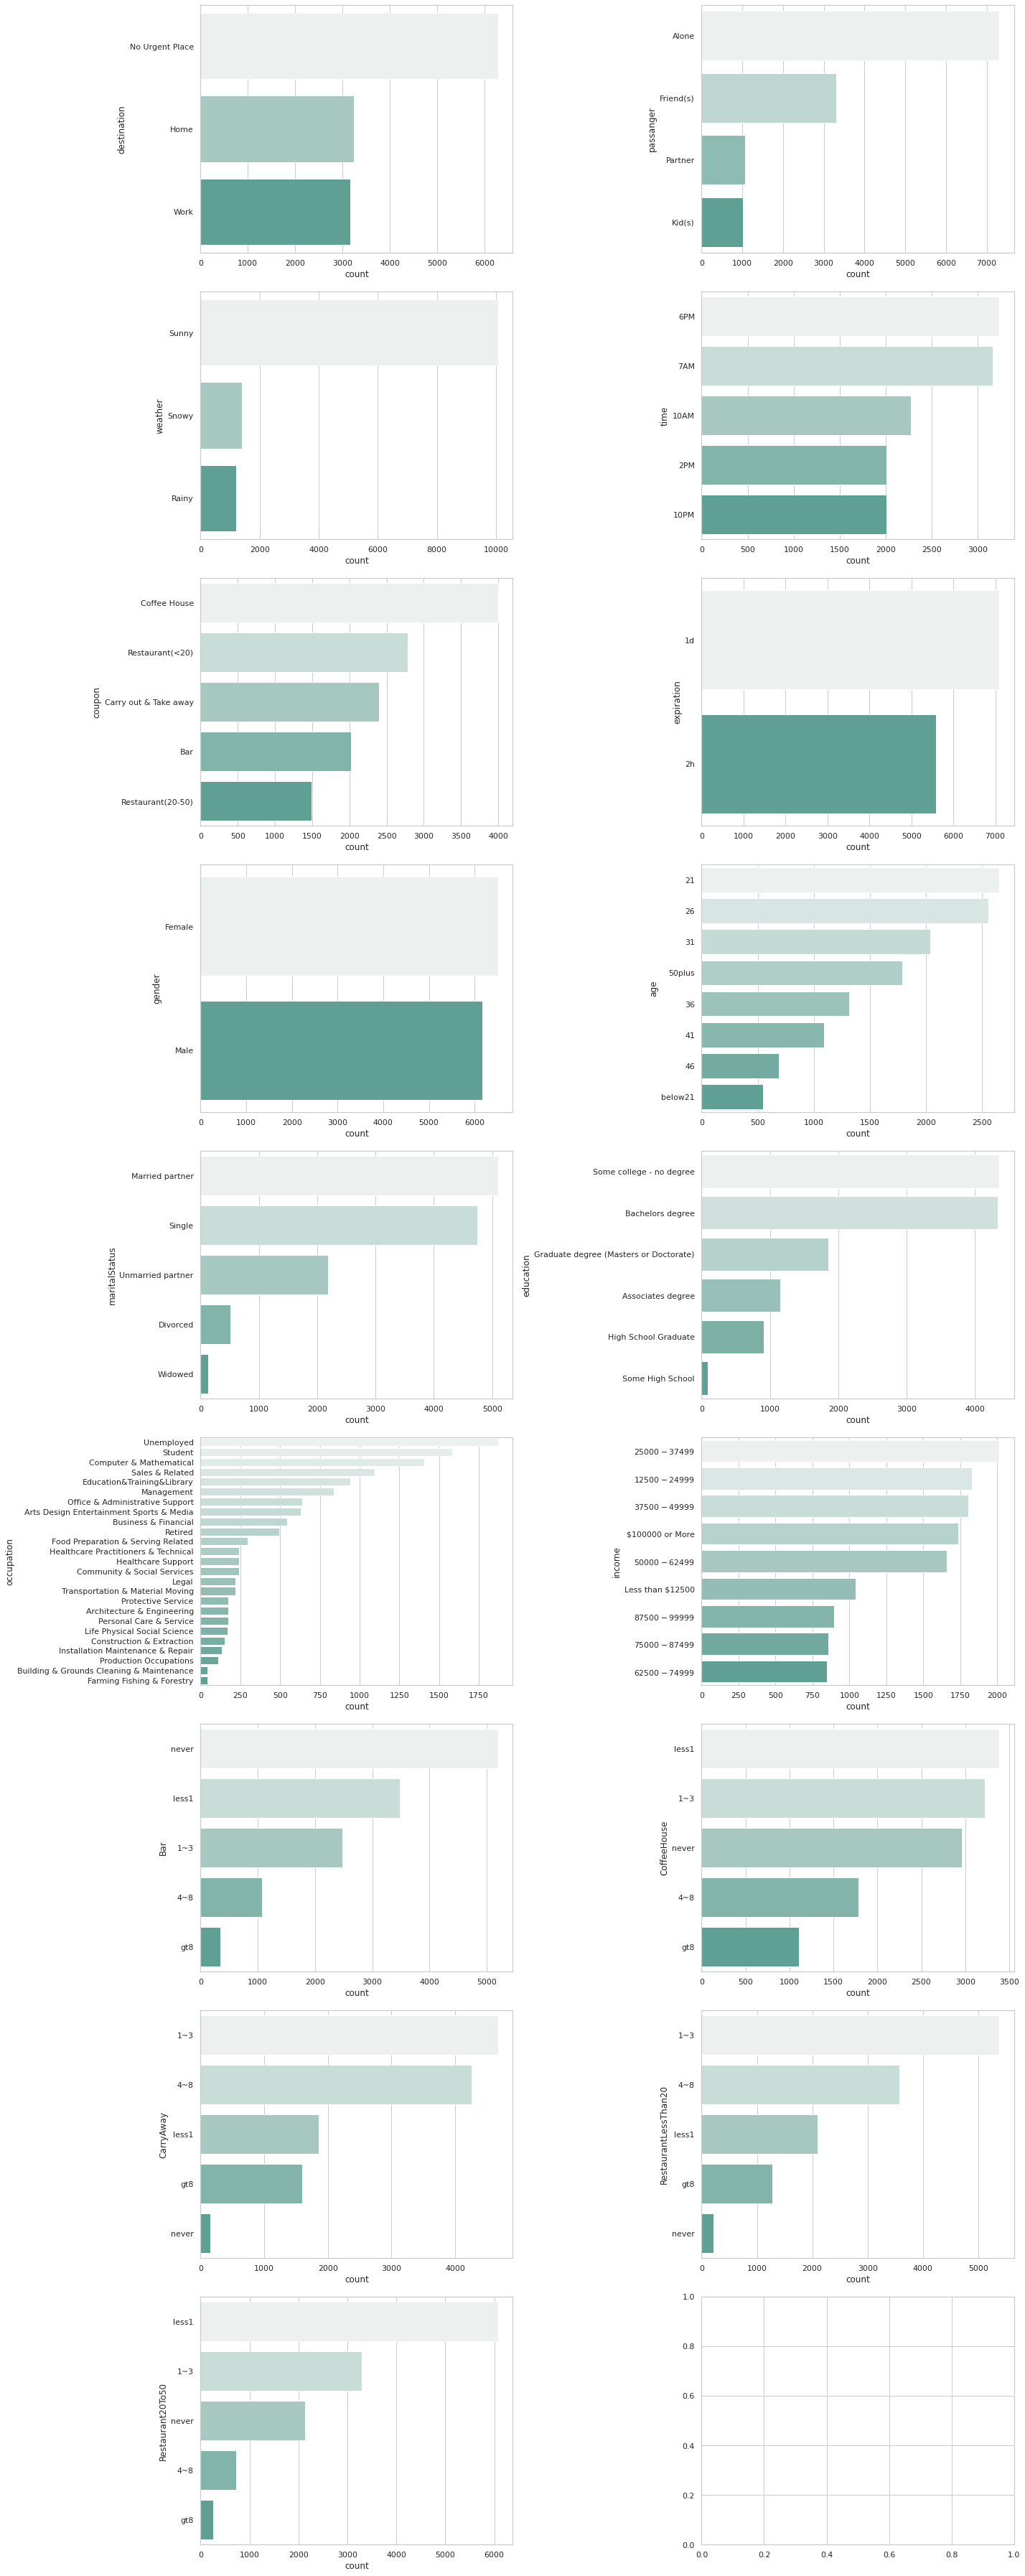

In [19]:
# code used from Kaggle to plot the categorical variable along with their count
fig, axes = plt.subplots(9, 2, figsize=(20,50))
axes = axes.flatten()

for ax, col in zip(axes, data.select_dtypes('category').columns):
    sns.countplot(y=col, data=data, ax=ax, 
                  palette="light:#5A9", order=data[col].value_counts().index);

plt.tight_layout()
plt.show()

In [20]:
data_object.columns

Index(['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income',
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50'],
      dtype='object')

In [21]:
category_mapping = {'less1':0,'1~3':1,'never':2,'4~8':3,'gt8':4}

data['Bar'] = data['Bar'].map(category_mapping)

data['CoffeeHouse'] = data['CoffeeHouse'].map(category_mapping)

data['CarryAway'] = data['CarryAway'].map(category_mapping)

data['RestaurantLessThan20'] = data['RestaurantLessThan20'].map(category_mapping)

data['Restaurant20To50'] = data['Restaurant20To50'].map(category_mapping)

In [22]:
iterative_imp = IterativeImputer(estimator=RandomForestClassifier(), 
                               initial_strategy='most_frequent',
                               max_iter=10, random_state=42)
categorical_data = data[['Bar','CoffeeHouse','Restaurant20To50','CarryAway','RestaurantLessThan20']]

categorical_data = iterative_imp.fit_transform(categorical_data)
categorical_data
data[['Bar','CoffeeHouse','Restaurant20To50','CarryAway','RestaurantLessThan20']]= categorical_data

In [23]:
high_cardinality = []
for each in data_object.columns:
    if len(data[each].unique())>=3:
        high_cardinality.append(each)

low_cardinality_columns = list(set(data_object.columns) - set(high_cardinality))

# low_cardinality_columns = list(set(low_cardinality_columns) - set(['Bar','CoffeeHouse','Restaurant20To50','CarryAway','RestaurantLessThan20']))

label_enc = LabelEncoder()
for each in low_cardinality_columns:
    data[each] = label_enc.fit_transform(data[each])

data = pd.get_dummies(data,columns=high_cardinality, drop_first=True, prefix=high_cardinality)

In [24]:
data.isnull().sum().sort_values(ascending=False)

temperature                      0
occupation_Protective Service    0
income_$50000 - $62499           0
income_$37500 - $49999           0
income_$25000 - $37499           0
                                ..
age_46                           0
age_41                           0
age_36                           0
age_31                           0
Restaurant20To50_4.0             0
Length: 92, dtype: int64

<AxesSubplot:>

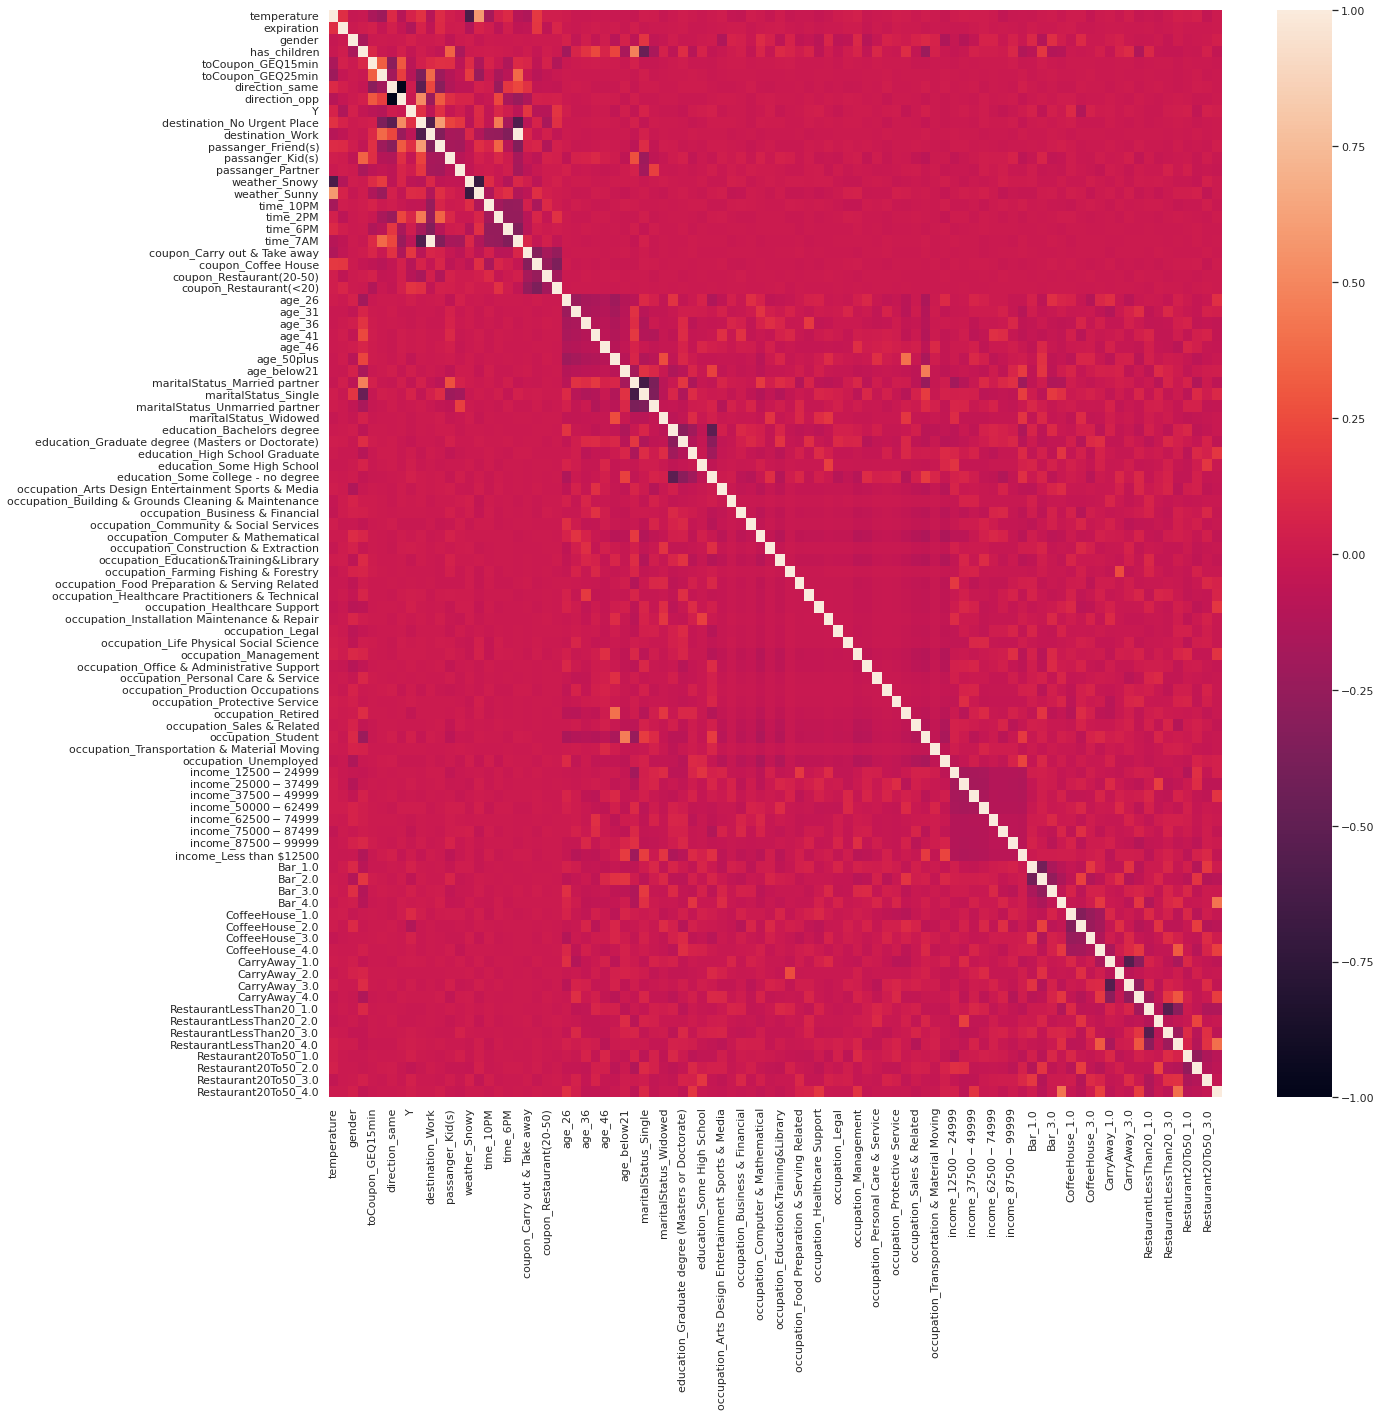

In [25]:
plt.figure(figsize=(20,20))
sns.heatmap(data.corr())

In [26]:
data.corr()

,temperature,expiration,gender,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y,destination_No Urgent Place,...,CarryAway_3.0,CarryAway_4.0,RestaurantLessThan20_1.0,RestaurantLessThan20_2.0,RestaurantLessThan20_3.0,RestaurantLessThan20_4.0,Restaurant20To50_1.0,Restaurant20To50_2.0,Restaurant20To50_3.0,Restaurant20To50_4.0
temperature,1.000000,0.124090,-0.025504,-0.019716,-0.155332,-0.216254,0.097085,-0.097085,0.061240,0.135549,...,0.029757,-0.025867,-0.012630,-0.029996,0.005221,0.032156,0.024766,0.041733,-0.041033,0.000240
expiration,0.124090,1.000000,-0.001264,0.016020,0.042740,-0.032977,0.033584,-0.033584,-0.129920,0.059236,...,-0.002439,-0.000418,0.006265,-0.009741,-0.002218,0.010199,-0.001349,-0.007424,-0.000008,0.002880
gender,-0.025504,-0.001264,1.000000,-0.159956,-0.007028,0.002743,-0.004496,0.004496,0.043969,0.006377,...,-0.006997,-0.018445,-0.010265,0.003542,-0.037431,0.014962,-0.009056,-0.007660,0.005900,0.033719
has_children,-0.019716,0.016020,-0.159956,1.000000,0.078211,-0.013722,-0.031620,0.031620,-0.045557,0.023348,...,0.104755,-0.126096,0.086934,-0.030787,-0.037534,-0.035633,-0.015532,-0.022884,0.043699,-0.042978
toCoupon_GEQ15min,-0.155332,0.042740,-0.007028,0.078211,1.000000,0.324984,-0.303533,0.303533,-0.081602,0.036904,...,0.000942,-0.008639,-0.002530,0.001790,0.000879,-0.008699,0.004597,-0.001144,-0.006673,-0.011391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RestaurantLessThan20_4.0,0.032156,0.010199,0.014962,-0.035633,-0.008699,-0.008128,-0.008249,0.008249,0.026674,0.012269,...,0.030613,0.292844,-0.291988,-0.044607,-0.211446,1.000000,0.057047,-0.106130,0.137326,0.393968
Restaurant20To50_1.0,0.024766,-0.001349,-0.009056,-0.015532,0.004597,-0.002735,-0.006376,0.006376,0.031907,0.006225,...,-0.038862,0.045336,0.004089,-0.018000,0.104396,0.057047,1.000000,-0.267958,-0.146031,-0.086281
Restaurant20To50_2.0,0.041733,-0.007424,-0.007660,-0.022884,-0.001144,0.011610,0.020208,-0.020208,-0.047733,-0.022645,...,-0.044898,-0.046332,-0.047577,0.222704,-0.090189,-0.106130,-0.267958,1.000000,-0.111729,-0.066014
Restaurant20To50_3.0,-0.041033,-0.000008,0.005900,0.043699,-0.006673,-0.008082,0.012097,-0.012097,0.043238,-0.001094,...,0.102044,-0.004589,-0.139297,-0.032784,0.128735,0.137326,-0.146031,-0.111729,1.000000,-0.035976


In [27]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['Y']), data['Y'], test_size=0.25, random_state=42)

In [28]:
lgb_classifier = lgbm.LGBMClassifier(boosting_type='goss')
lgb_classifier.fit(X_train,y_train)
lgb_predictions = lgb_classifier.predict(X_test)

In [29]:
print(metric.classification_report(y_test,lgb_predictions))

              precision    recall  f1-score   support

           0       0.73      0.65      0.69      1387
           1       0.75      0.81      0.78      1784

    accuracy                           0.74      3171
   macro avg       0.74      0.73      0.73      3171
weighted avg       0.74      0.74      0.74      3171



Roc AUC:0.812520206853518


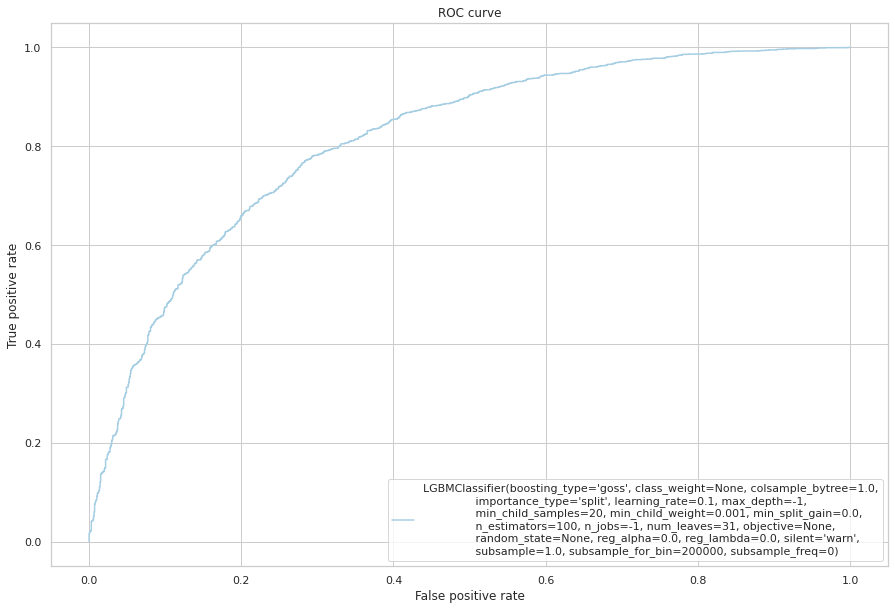

In [31]:
y_proba_lgb = lgb_classifier.predict_proba(X_test)[:,1]
print(f"Roc AUC:{metric.roc_auc_score(y_test, lgb_classifier.predict_proba(X_test)[:,1],average='macro')}")
fpr, tpr, thresholds = metric.roc_curve(y_test, y_proba_lgb)
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(fpr, tpr, label=lgb_classifier)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

## Creating best fit model with parameters obtained from GridSearchCV

In [46]:
param_grid = {
        "n_estimators": [300, 500, 700, 1000],
        "learning_rate": [0.01, 0.3],
        "num_leaves": [20, 40, 60],
        "max_depth": [-1, 3, 6, 9],
    }

In [ ]:
gv_search = GridSearchCV(lgbm.LGBMClassifier(random_state=42), cv=StratifiedKFold(n_splits=10), param_grid=param_grid)
gv_search.fit(data.drop(columns=['Y']), data['Y'])

##################################
Best Model Parameter with score
## Best Parameters -> {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 1000, 'num_leaves': 60}
Best Score -> 0.6970136573918706
##################################
##################################
Taking the best parameters from Grid Search and building the model.
##################################
     
     precision    recall  f1-score   support

           0       0.73      0.58      0.64      1128
           1       0.71      0.83      0.77      1409

    accuracy                               0.72      2537
    macro avg          0.72      0.70      0.70      2537
    weighted avg       0.72      0.72      0.71      2537

##################################
##################################

In [ ]:
lg = lgbm.LGBMClassifier()

In [44]:
best_lgbm = lgbm.LGBMClassifier(learning_rate=0.01, max_depth=-1, n_estimators=1000, num_leaves=60, random_state=42)
best_lgbm.fit(X_train, y_train)
best_lgbm_predict = best_lgbm.predict(X_test)

In [45]:
print(metric.classification_report(y_test,best_lgbm_predict))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      1387
           1       0.76      0.83      0.80      1784

    accuracy                           0.76      3171
   macro avg       0.76      0.75      0.75      3171
weighted avg       0.76      0.76      0.76      3171

